# IOR benchmark with pdwfs

https://ior.readthedocs.io/en/latest/

In [32]:
# %load utils.py
import itertools as it
from collections import namedtuple
from jinja2 import Template

IORCase = namedtuple("IORCase", 
                     field_names=["numTasks", "filePerProc", "collective", "segmentCount", "transferSize"])

def make_ior_script(api, numTasks, filePerProc, collective, segmentCount, transferSize):
    matrix = list(it.product(numTasks, filePerProc, collective, segmentCount, transferSize))
    cases = [IORCase(*case) for case in matrix]

    with open("ior_script.jinja2", "r") as f:
        template = Template(f.read())

    with open("ior_script_" + api, "w") as f:
        f.write(template.render(api=api, cases=cases))

## Build benchmark test cases

### Default parameters

In [33]:
numTasks=["1"]
filePerProc=["0"]
collective=["0"]
segmentCount=["1"]
transferSize = ["512k", "1m", "5m", "10m", "50m", "100m", "500m"]

### POSIX cases

In [34]:
make_ior_script("POSIX", numTasks, filePerProc, collective, segmentCount, transferSize)
#%cat ior_script_POSIX

### MPI-IO cases

In [35]:
# Parameters
numTasks=["2"]
filePerProc=["0"]  # other value 1
collective=["1"]  # other value 0

make_ior_script("MPIIO", numTasks, filePerProc, collective, segmentCount, transferSize) 
#% cat for ior_script_MPIIO

### Parallel HDF5

In [36]:
# same paramters as MPI-IO cases
make_ior_script("HDF5", numTasks, filePerProc, collective, segmentCount, transferSize) 

## Execute benchmarks

### POSIX

In [37]:
%%bash 
cd run
mpirun ior -f ../ior_script_POSIX > ior_results_disk_POSIX.out
# %cat ior_results_disk_POSIX.out

In [38]:
%%bash
cd run
pdwfs-redis restart &> /dev/null
pdwfs -p . -- mpirun ior -f ../ior_script_POSIX > ior_results_pdwfs_POSIX.out
# %cat ior_results_disk_POSIX.out

### MPI-IO

In [39]:
%%bash 
cd run
mpirun ior -f ../ior_script_MPIIO > ior_results_disk_MPIIO.out
# %cat ior_results_disk_MPIIO.out

In [40]:
%%bash
cd run
pdwfs-redis restart &> /dev/null
pdwfs -p . -- mpirun ior -f ../ior_script_MPIIO > ior_results_pdwfs_MPIIO.out
# %cat ior_results_disk_MPIIO.out

## Parallel HDF5

In [41]:
%%bash 
cd run
mpirun ior -f ../ior_script_HDF5 > ior_results_disk_HDF5.out
# %cat ior_results_disk_HDF5.out

In [42]:
%%bash
cd run
pdwfs-redis restart &> /dev/null
pdwfs -p . -- mpirun ior -f ../ior_script_HDF5 > ior_results_pdwfs_HDF5.out
# %cat ior_results_disk_HDF5.out

## Parse results in Pandas dataframe

In [43]:
def parse_ior_results(filename):
    """
    Parse IOR results in file given by filename and return a Pandas dataframe
    """
    import re
    import pandas

    start_line = None
    end_line = None
    with open(filename,'r') as f: 
        for i, line in enumerate(f.readlines()):
            if re.search("Summary of all tests:", line):
                 start_line = i + 1
            if re.search("Finished", line):
                end_line = i - 1

    return pandas.read_csv(filename, sep='\s+', skiprows=start_line, nrows=end_line-start_line)

In [44]:
df_disk_POSIX = parse_ior_results("run/ior_results_disk_POSIX.out")
#df_disk_POSIX

In [45]:
df_pdwfs_POSIX = parse_ior_results("run/ior_results_pdwfs_POSIX.out")
#df_pdwfs_POSIX

In [46]:
df_disk_MPIIO = parse_ior_results("run/ior_results_disk_MPIIO.out")
#df_disk_MPIIO

In [47]:
df_pdwfs_MPIIO = parse_ior_results("run/ior_results_pdwfs_MPIIO.out")
#df_pdwfs_MPIIO

In [48]:
df_disk_HDF5 = parse_ior_results("run/ior_results_disk_HDF5.out")
#df_disk_HDF5

In [49]:
df_pdwfs_HDF5 = parse_ior_results("run/ior_results_pdwfs_HDF5.out")
#df_pdwfs_HDF5

## Plot the results

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

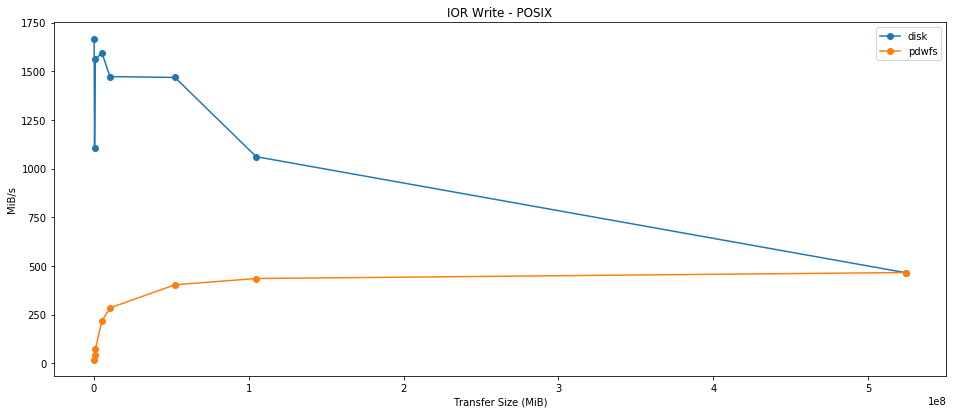

In [53]:
plt.xlabel("Transfer Size (MiB)")
plt.ylabel("MiB/s")
plt.title("IOR Write - POSIX")

df_disk = df_disk_POSIX
df_pdwfs = df_pdwfs_POSIX

fig = plt.gcf()
fig.set_size_inches(16, 6.5)

f = 1024*1024
plt.plot(df_disk["xsize"], df_disk["Max(MiB)"],'-o',label="disk")
plt.plot(df_pdwfs["xsize"], df_pdwfs["Max(MiB)"],'-o',label="pdwfs")

plt.legend(["disk","pdwfs"],loc="upper right")

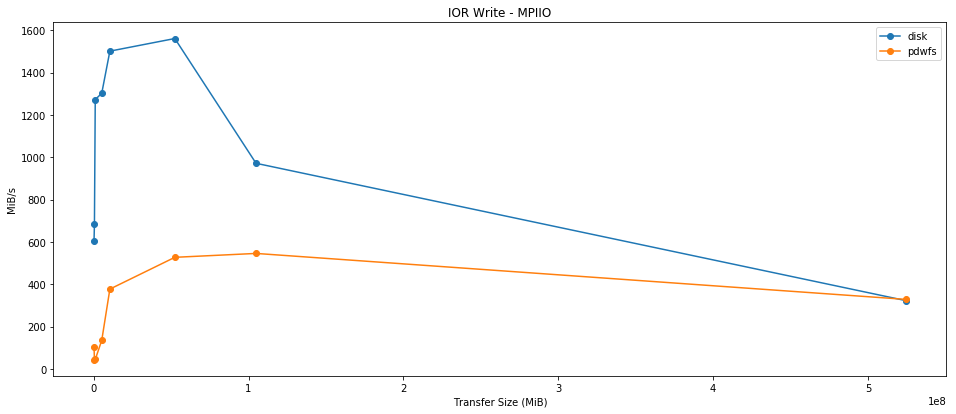

In [55]:
plt.xlabel("Transfer Size (MiB)")
plt.ylabel("MiB/s")
plt.title("IOR Write - MPIIO")

df_disk = df_disk_MPIIO
df_pdwfs = df_pdwfs_MPIIO

fig = plt.gcf()
fig.set_size_inches(16, 6.5)

f = 1024*1024
plt.plot(df_disk["xsize"], df_disk["Max(MiB)"],'-o',label="disk")
plt.plot(df_pdwfs["xsize"], df_pdwfs["Max(MiB)"],'-o',label="pdwfs")

plt.legend(["disk","pdwfs"],loc="upper right")

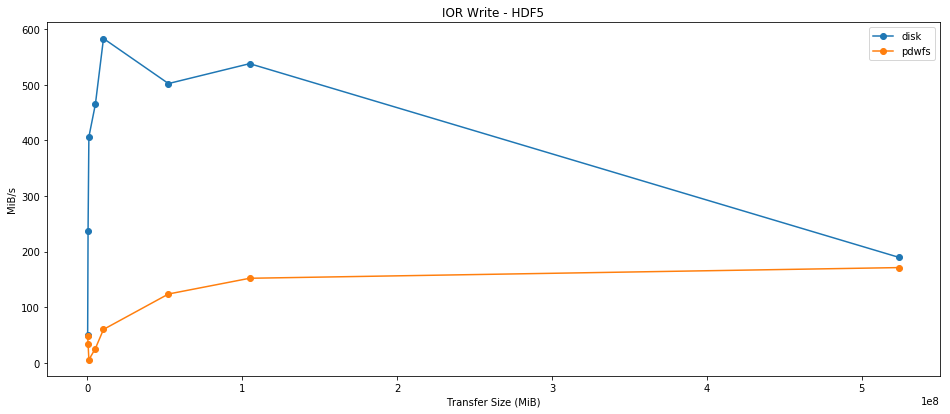

In [56]:
plt.xlabel("Transfer Size (MiB)")
plt.ylabel("MiB/s")
plt.title("IOR Write - HDF5")

df_disk = df_disk_HDF5
df_pdwfs = df_pdwfs_HDF5

fig = plt.gcf()
fig.set_size_inches(16, 6.5)

f = 1024*1024
plt.plot(df_disk["xsize"], df_disk["Max(MiB)"],'-o',label="disk")
plt.plot(df_pdwfs["xsize"], df_pdwfs["Max(MiB)"],'-o',label="pdwfs")

plt.legend(["disk","pdwfs"],loc="upper right")